# PCA Decomposition

In [1]:
from os import listdir
from os.path import join

import cv2
import numpy as np
from tqdm import tqdm
from scipy.ndimage import imread
from imageutils import imshow
from sklearn.decomposition import TruncatedSVD

In [2]:
TRAIN_PATH       = join('..', 'data', 'raw', 'train')
TRAIN_MASKS_PATH = join(TRAIN_PATH, 'masks')
MASK_EXT         = 'gif'

In [3]:
masks = {f[:-9] : join(TRAIN_MASKS_PATH, f) for f in listdir(TRAIN_MASKS_PATH) if f.endswith("gif")}

In [4]:
image_rows = 1280
image_cols = 1918
dest_rows , dest_cols = (512, 512)

In [5]:
total = len(masks)

In [6]:
train = np.zeros((total, dest_rows, dest_cols))
i = 0
for name, mask_path in tqdm(masks.items()):
    mask = imread(mask_path, mode='L')
    train[i] = cv2.resize(mask, None, fx=dest_cols/image_cols, fy=dest_rows/image_rows, interpolation = cv2.INTER_AREA)
    i += 1

100%|██████████| 5088/5088 [01:57<00:00, 43.42it/s]


In [7]:
pca = TruncatedSVD(n_components=250).fit(train.reshape(-1, dest_rows * dest_cols))

In [8]:
smooth = 1.
def dice_coef(A, B):
    y_true_f = A.flatten()
    y_pred_f = B.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [9]:
mask = imread('../data/raw/train/masks/cd2e588ef1c5_01_mask.gif', mode='L')

In [44]:
crop = mask[450:1100, 512:1350]

In [45]:
mini = cv2.resize(crop, None, fx=dest_cols/image_cols, fy=dest_rows/image_rows, interpolation = cv2.INTER_AREA)

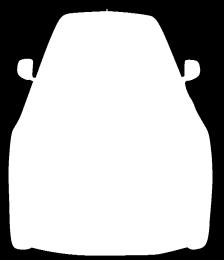

In [46]:
imshow(mini)

In [47]:
maxi = cv2.resize(mini, None, fx=image_cols/dest_cols, fy=image_rows/dest_rows, interpolation = cv2.INTER_LINEAR)

In [48]:
maxi = (maxi > 0.5)

In [49]:
imshow(255*maxi.astype('uint8'))

In [50]:
Y_pred = mini
Y128 = cv2.resize(Y_pred.squeeze(), (512, 512))
Y128 = (Y128 > 0).astype(np.float32)
Y_r = pca.transform(Y128.reshape(-1, dest_rows * dest_cols))
mask2 = pca.inverse_transform(Y_r).reshape(dest_rows, dest_cols)
mask2 = cv2.resize(mask2, (1918, 1280)) > 0.5

In [51]:
mask2 = (mask2 > 0.5)

In [54]:
nn = np.zeros((image_rows, image_cols))

In [64]:
nn[450:1100, 511:1350] = maxi

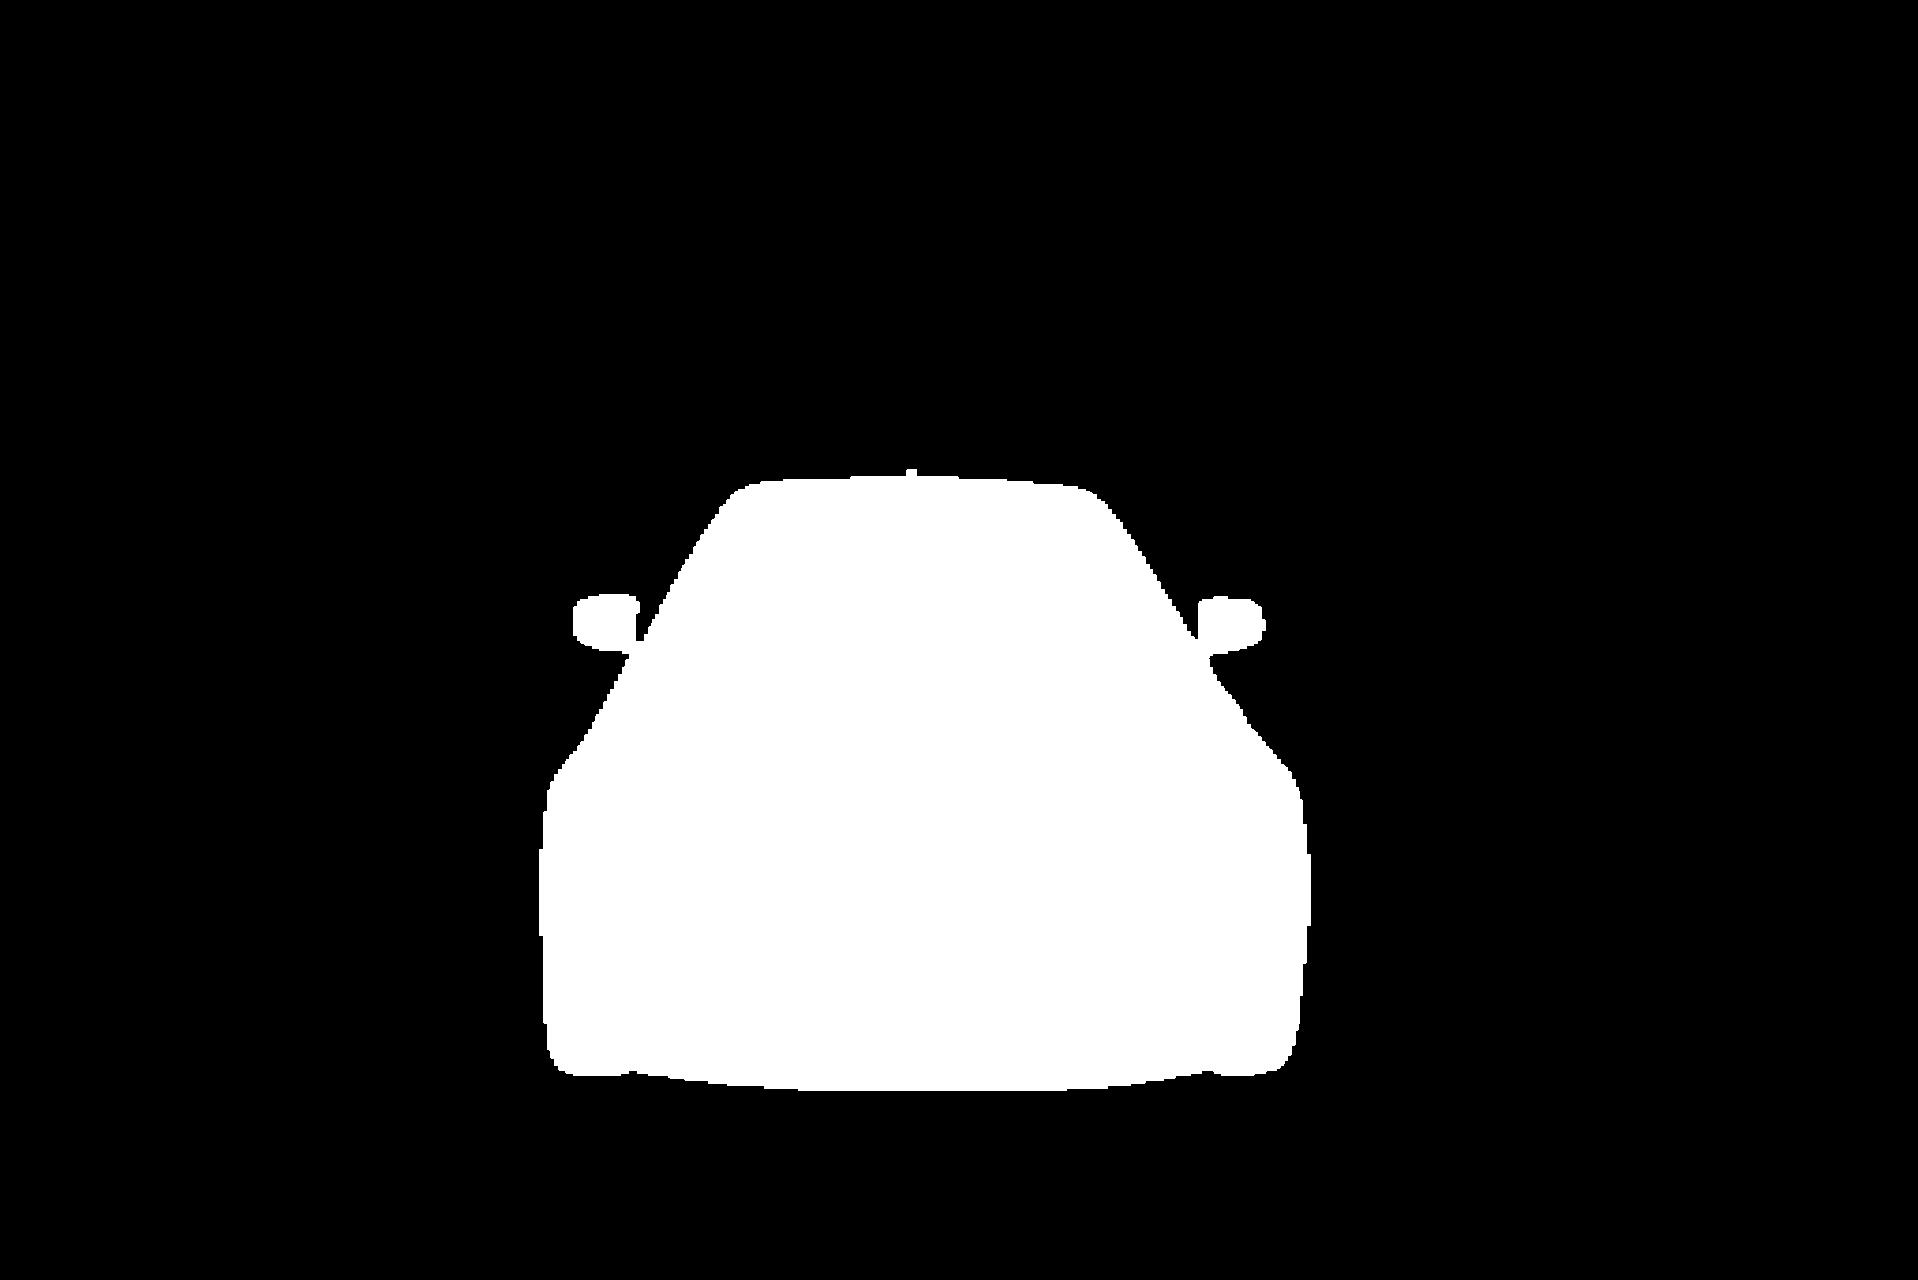

In [65]:
imshow(255*nn.astype('uint8'))

In [66]:
print(dice_coef((mask/255).astype('uint8'), nn.astype('uint8')))

0.988537031728


In [62]:
print(dice_coef((mask/255).astype('uint8'), maxi.astype('uint8')))

ValueError: operands could not be broadcast together with shapes (2455040,) (545350,) 